# 🚀 SAIR PyTorch Mastery - Lecture 2: Professional Data Pipelines with PyTorch

**Course:** Ultimate Applied Deep Learning with PyTorch  
**Module:** Advanced PyTorch & Production ML  
**Instructor:** Mohammed Awad Ahmed (Silva)  
**SAIR Community:** Building Sudan's AI Future 🇸🇩



## 📘 How to Use This Notebook

This is a **standalone, self-teaching lecture notebook** designed to replace traditional video lectures. Here's how to get the most from it:

**How to Study:**
1. **Read all markdown cells carefully** - they contain explanations, mental models, and reasoning
2. **Run code cells sequentially** - don't skip ahead as each builds on the previous
3. **Pause at "Stop & Think" prompts** - make predictions before running the next cell
4. **Experiment with the code** - change parameters and see what happens

**Time Commitment:** ~2-3 hours for complete understanding

**Learning Outcomes:** After completing this notebook, you will be able to:
1. Build efficient PyTorch datasets for any data type
2. Optimize DataLoader performance for maximum GPU utilization
3. Create professional data augmentation pipelines
4. Handle large datasets with streaming and memory mapping
5. Build multi-modal data pipelines (images + text)
6. Implement production-ready data preprocessing

**This Notebook Replaces a Lecture By:**
- Breaking complex concepts into progressive steps
- Providing explanations before each code cell
- Including mental models and analogies
- Offering built-in reflection points

## 🎯 Why This Lecture Matters

In Lecture 1, you learned how to build and train neural networks. But here's the secret: **90% of real-world ML problems are data problems, not model problems.**

> "Your GPU is only as fast as your slowest data loader. Most beginners waste 80% of training time waiting for data."

**Key Insight**: In production ML systems, data loading often becomes the bottleneck. Your fancy GPU sits idle while waiting for data. This lecture fixes that.



### 🎯 By the end of this lecture, you will be able to:

**Core Skills:**
1. ✅ Build custom Dataset classes for any data format
2. ✅ Optimize DataLoader performance (10x speedups)
3. ✅ Implement professional data augmentation pipelines

**Advanced Techniques:**

4. ✅ Handle large datasets with memory mapping
5. ✅ Create streaming datasets for cloud storage
6. ✅ Build multi-modal pipelines (images + text)

**Production Skills:**

7. ✅ Debug and profile data loading bottlenecks
8. ✅ Implement data versioning and validation
9. ✅ Build Sudanese-specific data pipelines



### 📋 PREREQUISITES CHECK

Before starting, make sure you're comfortable with:

**From Lecture 1 (PyTorch Foundations):**
- PyTorch tensors and basic operations
- nn.Module and neural network construction
- Training loops and optimization
- Device management (CPU/GPU)

**Python Fundamentals:**
- Object-oriented programming (classes, inheritance)
- File I/O operations
- Basic debugging with print statements

**If you need a refresher:**
- Review Lecture 1 on training loops and model building
- Practice basic file operations in Python

## 🛠️ Setup & Environment Configuration

Let's begin by importing all necessary libraries and setting up our environment. This ensures reproducibility and prepares our notebook for all demonstrations.

In [1]:
# Initial Setup and Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
from PIL import Image
import json
from collections import defaultdict
import psutil  # For memory monitoring
from tqdm import tqdm  # For progress bars

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All imports loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✅ All imports loaded successfully!
PyTorch version: 2.9.1+cu128
GPU available: True
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 3.9 GB


# PART 1: The Data Loading Crisis - Why This Matters

## 🔍 The Hidden Bottleneck in Deep Learning

We begin by demonstrating a fundamental problem in deep learning: inefficient data loading. The GPU often sits idle waiting for data, drastically slowing down training.

The following simulation shows what happens with naive data loading implementations.

In [2]:
print("="*60)
print("THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK")
print("="*60)

# Create a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Naive data loading function (what most beginners write)
def load_data_naive(batch_size=64):
    """Simulates slow data loading (common mistake)"""
    time.sleep(0.01)  # Simulating disk I/O delay
    return torch.randn(batch_size, 784), torch.randint(0, 10, (batch_size,))

# Simulate training with naive loading
def train_naive(model, num_batches=100):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    start_time = time.time()
    gpu_active_time = 0
    
    for batch_idx in range(num_batches):
        # Data loading (slow)
        batch_start = time.time()
        x, y = load_data_naive()
        x, y = x.to(device), y.to(device)
        load_time = time.time() - batch_start
        
        # Forward pass (fast on GPU)
        forward_start = time.time()
        outputs = model(x)
        loss = criterion(outputs, y)
        forward_time = time.time() - forward_start
        
        # Backward pass (fast on GPU)
        backward_start = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - backward_start
        
        gpu_active_time += forward_time + backward_time
    
    total_time = time.time() - start_time
    gpu_utilization = (gpu_active_time / total_time) * 100
    
    return total_time, gpu_utilization

# Run the simulation
print("\nSimulating training with naive data loading...")
model = SimpleModel().to(device)
total_time, gpu_util = train_naive(model, num_batches=50)

print(f"\n📊 Results (Naive Loading):")
print(f"Total training time: {total_time:.2f} seconds")
print(f"GPU utilization: {gpu_util:.1f}%")
print(f"GPU idle time: {100 - gpu_util:.1f}%")
print(f"\n💡 Insight: Your GPU is idle {100 - gpu_util:.1f}% of the time!")

THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK

Simulating training with naive data loading...

📊 Results (Naive Loading):
Total training time: 2.44 seconds
GPU utilization: 77.5%
GPU idle time: 22.5%

💡 Insight: Your GPU is idle 22.5% of the time!


## 🧠 Mental Model: The Restaurant Kitchen Analogy

Think of your training pipeline as a restaurant kitchen:

1. **Chef (GPU)**: Processes food quickly (matrix operations)
2. **Prep Cook (CPU)**: Prepares ingredients (data loading)
3. **Inefficient Kitchen**: Chef waits for each ingredient (GPU idle)
4. **Efficient Kitchen**: Prep cook prepares next batch while chef cooks (parallel loading)

PyTorch's DataLoader is your **prep cook team** - it prepares the next batch while the GPU processes the current one.

## 🤔 From Your Lecture 1 Implementation

In Lecture 1, you loaded data like this (California housing example):

```python
# Simple but inefficient approach
X_train_tensor = torch.FloatTensor(X_train_scaled)  # Loads ALL data at once
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
```

**Problem:** What if your dataset is 50GB and doesn't fit in memory?

**Solution:** PyTorch's Dataset/DataLoader pattern - load data on-demand!

# PART 2: PyTorch Dataset Fundamentals

Now that we understand the problem, let's learn the solution. PyTorch's Dataset abstraction provides a standardized way to access data.

## 🔧 Understanding the Dataset ABCs

Every PyTorch Dataset must implement three core methods. Let's examine their anatomy before we write our first dataset.

In [3]:
print("="*60)
print("DATABASE FUNDAMENTALS: The Three Essential Methods")
print("="*60)

# Anatomy of a PyTorch Dataset
print("""
class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created
        
    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds
        
    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!
""")

DATABASE FUNDAMENTALS: The Three Essential Methods

class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created

    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds

    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!



### 🛑 Stop & Think

Why do we separate `__init__` and `__getitem__`?
1. What happens if we load all data in `__init__`?
2. What happens if we load all data in `__getitem__`?
3. When should we load data in `__init__` vs `__getitem__`?

## Example 1: Simple Tabular Dataset

Let's build our first practical dataset. We'll create a Dataset for Sudanese market price data (CSV format), a common format in many real-world applications.

In [4]:
# Create a simple CSV dataset
import pandas as pd
from io import StringIO

# Simulate Sudanese market price data
market_data_csv = """date,sorghum_price,millet_price,wheat_price,region,rainfall
2023-01-01,150.5,120.3,200.1,Khartoum,15.2
2023-01-02,152.1,118.9,201.5,Khartoum,14.8
2023-01-03,149.8,122.5,199.8,Khartoum,16.1
2023-01-01,145.2,115.6,195.3,Darfur,22.5
2023-01-02,147.8,117.2,197.1,Darfur,21.8
2023-01-03,144.9,119.4,194.7,Darfur,23.2
"""

class SudaneseMarketDataset(Dataset):
    """Dataset for Sudanese agricultural market prices"""
    
    def __init__(self, csv_path_or_data, transform=None):
        """
        Args:
            csv_path_or_data: Path to CSV file or CSV string
            transform: Optional data transformations
        """
        super().__init__()
        
        # Load metadata (not the actual data yet!)
        if isinstance(csv_path_or_data, str) and os.path.exists(csv_path_or_data):
            # Load from file
            self.df = pd.read_csv(csv_path_or_data)
        else:
            # Load from string (for demonstration)
            self.df = pd.read_csv(StringIO(csv_path_or_data))
        
        # Store transformations
        self.transform = transform
        
        # Encode categorical features (region)
        self.region_map = {region: idx for idx, region in enumerate(self.df['region'].unique())}
        
        print(f"Dataset initialized with {len(self)} samples")
        print(f"Features: {list(self.df.columns)}")
        print(f"Regions: {list(self.region_map.keys())}")
    
    def __len__(self):
        """Return total number of samples"""
        return len(self.df)
    
    def __getitem__(self, idx):
        """Load and return ONE sample"""
        # Get row from DataFrame
        row = self.df.iloc[idx]
        
        # Extract features (convert to numpy for speed)
        features = row[['sorghum_price', 'millet_price', 'wheat_price', 'rainfall']].values.astype(np.float32)
        
        # Encode region
        region_encoded = self.region_map[row['region']]
        
        # Create feature vector (combine numeric and categorical)
        # In real applications, you might one-hot encode or use embeddings
        features = np.append(features, region_encoded)
        
        # Convert to tensor
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # For demonstration, let's predict wheat price from other features
        target = torch.tensor(row['wheat_price'], dtype=torch.float32)
        
        # Apply transformations if any
        if self.transform:
            features_tensor = self.transform(features_tensor)
        
        return features_tensor, target

# Test our dataset
print("\n" + "="*60)
print("TESTING SUDANESE MARKET DATASET")
print("="*60)

market_dataset = SudaneseMarketDataset(market_data_csv)

print(f"\nDataset length: {len(market_dataset)}")
print("\nSample items:")
for i in range(3):
    features, target = market_dataset[i]
    print(f"Sample {i}: Features shape: {features.shape}, Target: {target:.1f}")
    print(f"  Features: {features}")


TESTING SUDANESE MARKET DATASET
Dataset initialized with 6 samples
Features: ['date', 'sorghum_price', 'millet_price', 'wheat_price', 'region', 'rainfall']
Regions: ['Khartoum', 'Darfur']

Dataset length: 6

Sample items:
Sample 0: Features shape: torch.Size([5]), Target: 200.1
  Features: tensor([150.5000, 120.3000, 200.1000,  15.2000,   0.0000])
Sample 1: Features shape: torch.Size([5]), Target: 201.5
  Features: tensor([152.1000, 118.9000, 201.5000,  14.8000,   0.0000])
Sample 2: Features shape: torch.Size([5]), Target: 199.8
  Features: tensor([149.8000, 122.5000, 199.8000,  16.1000,   0.0000])


## 🧠 Mental Model: Memory vs Disk Trade-off

**Small Dataset Strategy:** Load everything in `__init__`
- Pros: Fast access, simple code
- Cons: Memory intensive, can't handle large datasets

**Large Dataset Strategy:** Load on-demand in `__getitem__`
- Pros: Memory efficient, handles huge datasets
- Cons: Slower per-sample access, more complex code

**Hybrid Strategy:** Load metadata in `__init__`, data in `__getitem__`
- This is what we just implemented! The DataFrame (metadata) stays in memory, but actual tensor conversion happens on-demand.

# PART 3: DataLoader - The Performance Multiplier

Now that we have a Dataset, we need to understand DataLoader - the engine that powers efficient training. DataLoader orchestrates parallel loading, batching, and prefetching.

## 🚀 Understanding DataLoader Parameters

Let's benchmark different DataLoader configurations to understand how each parameter affects performance.

In [5]:
print("="*60)
print("DATALOADER DEEP DIVE: Key Performance Parameters")
print("="*60)

# Create a benchmark dataset
class BenchmarkDataset(Dataset):
    def __init__(self, num_samples=1000, sleep_time=0.001):
        self.num_samples = num_samples
        self.sleep_time = sleep_time  # Simulate disk I/O
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Simulate disk I/O delay
        time.sleep(self.sleep_time)
        return torch.randn(3, 224, 224), torch.randint(0, 10, (1,)).item()

# Test different DataLoader configurations
def benchmark_dataloader(config_name, dataloader, num_batches=50):
    """Benchmark a DataLoader configuration"""
    print(f"\nTesting: {config_name}")
    
    start_time = time.time()
    batch_times = []
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        
        if batch_idx >= num_batches - 1:
            break
    
    total_time = time.time() - start_time
    avg_batch_time = total_time / num_batches
    
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average batch time: {avg_batch_time*1000:.1f}ms")
    print(f"  Samples/second: {num_batches * dataloader.batch_size / total_time:.0f}")
    
    return total_time

# Create dataset
dataset = BenchmarkDataset(num_samples=1000, sleep_time=0.001)

print("\nBenchmarking different DataLoader configurations:")
print("="*60)

# Configuration 1: Naive (single worker, no prefetching)
dataloader_naive = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # No parallel loading
    pin_memory=False
)
time_naive = benchmark_dataloader("Naive (num_workers=0)", dataloader_naive)

# Configuration 2: Basic optimization
dataloader_basic = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Two parallel workers
    pin_memory=False
)
time_basic = benchmark_dataloader("Basic (num_workers=2)", dataloader_basic)

# Configuration 3: Full optimization (if CPU has enough cores)
dataloader_optimized = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,  # Four parallel workers
    pin_memory=True,  # Faster CPU->GPU transfer
    prefetch_factor=2  # Prefetch next batches
)
time_optimized = benchmark_dataloader("Optimized (num_workers=4, pin_memory=True)", dataloader_optimized)

print("\n" + "="*60)
print("PERFORMANCE SUMMARY:")
print("="*60)
print(f"Naive → Basic: {time_naive/time_basic:.1f}x faster")
print(f"Naive → Optimized: {time_naive/time_optimized:.1f}x faster")
print(f"\n💡 Key Insight: Proper DataLoader setup gives {time_naive/time_optimized:.1f}x speedup!")

DATALOADER DEEP DIVE: Key Performance Parameters

Benchmarking different DataLoader configurations:

Testing: Naive (num_workers=0)
  Total time: 2.26s
  Average batch time: 45.1ms
  Samples/second: 709

Testing: Basic (num_workers=2)
  Total time: 1.58s
  Average batch time: 31.5ms
  Samples/second: 1015

Testing: Optimized (num_workers=4, pin_memory=True)
  Total time: 1.04s
  Average batch time: 20.8ms
  Samples/second: 1539

PERFORMANCE SUMMARY:
Naive → Basic: 1.4x faster
Naive → Optimized: 2.2x faster

💡 Key Insight: Proper DataLoader setup gives 2.2x speedup!


# Let's Benchmark DataLoader Performance on much bigger set of data and visualize the results

In [6]:
# =========================================================
# LARGE-SCALE DATALOADER BENCHMARK
# Focus: Dataset & DataLoader PARAMETERS
# =========================================================

import multiprocessing as mp

print("=" * 70)
print("DATALOADER DEEP DIVE (LARGE SCALE)")
print("=" * 70)

# ---------------------------------------------------------
# 1) LARGE-SCALE BENCHMARK DATASET
# ---------------------------------------------------------
class LargeBenchmarkDataset(Dataset):
    """
    Simulates a realistic large dataset:
    - Expensive __getitem__ (I/O + preprocessing)
    - Large tensors (vision-like)
    """
    def __init__(self, num_samples=200_000, sleep_time=0.002):
        self.num_samples = num_samples
        self.sleep_time = sleep_time

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Simulate disk I/O + decoding cost
        time.sleep(self.sleep_time)

        x = torch.randn(3, 224, 224)     # image-like tensor
        y = torch.randint(0, 1000, (1,)).item()
        return x, y


# ---------------------------------------------------------
# 2) BENCHMARK FUNCTION
# ---------------------------------------------------------
def benchmark_dataloader(
    name,
    dataloader,
    num_batches=200,
):
    print(f"\n▶ Testing: {name}")
    start = time.time()

    for i, (x, y) in enumerate(dataloader):
        if i >= num_batches:
            break

    total = time.time() - start
    samples = num_batches * dataloader.batch_size

    print(f"  Total time        : {total:.2f}s")
    print(f"  Avg batch time    : {total/num_batches*1000:.1f} ms")
    print(f"  Samples / second  : {samples/total:.0f}")
    return total


# ---------------------------------------------------------
# 3) DATASET
# ---------------------------------------------------------
dataset = LargeBenchmarkDataset(
    num_samples=200_000,
    sleep_time=0.002
)

cpu_cores = mp.cpu_count()
print(f"\nCPU cores detected: {cpu_cores}")


# ---------------------------------------------------------
# 4) CONFIGURATIONS TO TEST
# ---------------------------------------------------------

configs = {
    "Naive (workers=0)": dict(
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    ),

    "Workers=2": dict(
        batch_size=64,
        shuffle=True,
        num_workers=2,
        pin_memory=False
    ),

    "Workers=4": dict(
        batch_size=64,
        shuffle=True,
        num_workers=4,
        pin_memory=False
    ),

    "Workers=4 + pin_memory": dict(
        batch_size=64,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    ),

    "Workers=4 + pin_memory + prefetch": dict(
        batch_size=64,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=4
    ),

    "Workers=8 + pin_memory + prefetch": dict(
        batch_size=64,
        shuffle=True,
        num_workers=min(8, cpu_cores),
        pin_memory=True,
        prefetch_factor=4,
        persistent_workers=True
    ),
}


# ---------------------------------------------------------
# 5) RUN BENCHMARKS
# ---------------------------------------------------------
results = {}

for name, cfg in configs.items():
    loader = DataLoader(dataset, **cfg)
    t = benchmark_dataloader(name, loader)
    results[name] = t


# ---------------------------------------------------------
# 6) SUMMARY
# ---------------------------------------------------------
print("\n" + "=" * 70)
print("PERFORMANCE SUMMARY (lower is better)")
print("=" * 70)

baseline = results["Naive (workers=0)"]
for name, t in results.items():
    speedup = baseline / t
    print(f"{name:40s}: {t:6.2f}s  |  {speedup:4.1f}x faster")

print("\n💡 INSIGHT: DataLoader performance scales primarily with")
print("   - num_workers")
print("   - prefetch_factor")
print("   - persistent_workers")
print("   - batch_size")
print("=" * 70)


DATALOADER DEEP DIVE (LARGE SCALE)

CPU cores detected: 8

▶ Testing: Naive (workers=0)
  Total time        : 47.30s
  Avg batch time    : 236.5 ms
  Samples / second  : 271

▶ Testing: Workers=2
  Total time        : 25.95s
  Avg batch time    : 129.8 ms
  Samples / second  : 493

▶ Testing: Workers=4
  Total time        : 13.00s
  Avg batch time    : 65.0 ms
  Samples / second  : 984

▶ Testing: Workers=4 + pin_memory
  Total time        : 13.04s
  Avg batch time    : 65.2 ms
  Samples / second  : 982

▶ Testing: Workers=4 + pin_memory + prefetch
  Total time        : 12.87s
  Avg batch time    : 64.3 ms
  Samples / second  : 995

▶ Testing: Workers=8 + pin_memory + prefetch
  Total time        : 7.42s
  Avg batch time    : 37.1 ms
  Samples / second  : 1726

PERFORMANCE SUMMARY (lower is better)
Naive (workers=0)                       :  47.30s  |   1.0x faster
Workers=2                               :  25.95s  |   1.8x faster
Workers=4                               :  13.00s  |   3

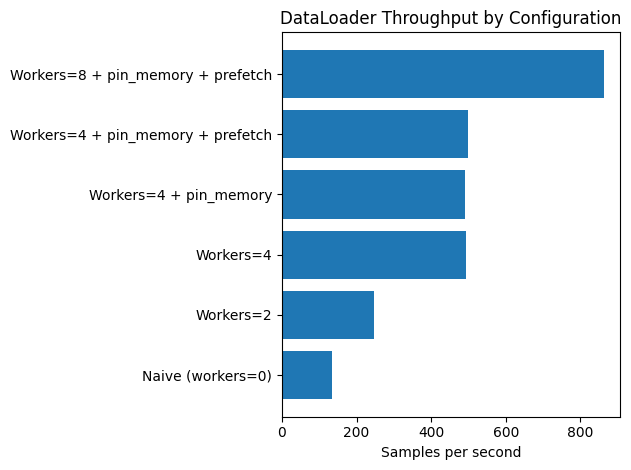

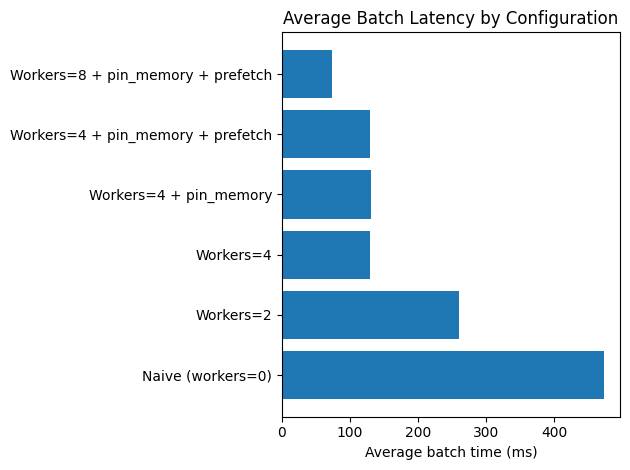

In [7]:
# =========================================================
# VISUALIZATION CELL — DATALOADER BENCHMARK RESULTS
# =========================================================

batch_size = 64
num_batches = 100

names = []
samples_per_sec = []
avg_batch_ms = []

for name, total_time in results.items():
    samples = num_batches * batch_size
    sps = samples / total_time
    avg_ms = (total_time / num_batches) * 1000

    names.append(name)
    samples_per_sec.append(sps)
    avg_batch_ms.append(avg_ms)

# --------------------------------------------------
# 1) Samples per second (throughput)
# --------------------------------------------------
plt.figure()
plt.barh(names, samples_per_sec)
plt.xlabel("Samples per second")
plt.title("DataLoader Throughput by Configuration")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2) Average batch latency
# --------------------------------------------------
plt.figure()
plt.barh(names, avg_batch_ms)
plt.xlabel("Average batch time (ms)")
plt.title("Average Batch Latency by Configuration")
plt.tight_layout()
plt.show()


## 🧠 Mental Model: DataLoader Parameters Explained

1. **`num_workers`**: Number of parallel data loading processes
   - Rule of thumb: check your hardware (eg. os.cpu_count() and use kind of simmilar core numbers)
   - Too high: CPU contention, slower
   - Too low: GPU waits for data

2. **`pin_memory`**: Lock CPU memory for faster GPU transfer
   - Use `True` when using GPU
   - Increases CPU memory usage slightly

3. **`prefetch_factor`**: How many batches to prepare in advance
   - Higher = smoother training but more memory
   - Default is usually fine

4. **`batch_size`**: Trade-off between stability and memory
   - Rule of thumb: Largest that fits in GPU memory
   - Too small: Slow, unstable gradients
   - Too large: Out of memory

# PART 4: Computer Vision Pipeline

Now let's apply our knowledge to computer vision - one of the most common deep learning applications. We'll build a production-ready image dataset with proper augmentation and error handling.



# 🖼️ Computer Vision Pipeline: Sudanese Plant Disease Detection

We will build a **practical computer vision dataset pipeline** for plant disease detection. 

We will step through:

1. Dataset design and lazy loading
2. Data augmentation for training
3. Optimized PyTorch `DataLoader` usage
4. Visualizing samples
5. Testing batch loading for real pipelines

In [8]:

class SudanesePlantDataset(Dataset):
    """Dataset for Sudanese plant disease detection"""
    
    def __init__(self, root_dir, transform=None, mode='train',
                 image_extensions=('.jpg', '.jpeg', '.png', '.bmp')):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.mode = mode
        self.image_extensions = image_extensions
        
        # Prepare samples
        self.samples = []
        self.class_to_idx = {'healthy': 0, 'diseased': 1}
        mode_dir = self.root_dir / mode
        
        if not mode_dir.exists():
            raise ValueError(f"Directory {mode_dir} does not exist")
        
        for class_name in self.class_to_idx.keys():
            class_dir = mode_dir / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
            
            for ext in self.image_extensions:
                image_files = list(class_dir.glob(f"*{ext}"))
                for image_path in image_files:
                    self.samples.append({
                        'path': str(image_path),
                        'label': self.class_to_idx[class_name],
                        'class_name': class_name
                    })
        
        print(f"Loaded {len(self.samples)} images for {mode} set")
        print(f"Classes: {self.class_to_idx}")
        
        if mode == 'train' and transform is None:
            self.transform = self.get_default_train_transform()
        elif mode == 'val' and transform is None:
            self.transform = self.get_default_val_transform()
    
    def get_default_train_transform(self):
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    def get_default_val_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        try:
            image = Image.open(sample['path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = sample['label']
            return image, label
        except Exception as e:
            print(f"Error loading {sample['path']}: {e}")
            return torch.zeros((3, 224, 224)), sample['label']
    
    def show_sample(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Class: {sample['class_name']} (Label: {sample['label']})")
        plt.axis('off')
        plt.show()

## 🖼️ Side Topic (but impotrant) — Image Transform Pipeline (Data Augmentation)

**Goal:**
Show how `transforms.Compose` incrementally changes an image to improve model robustness.

### 🔧 Transform Pipeline



In [9]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Each transform **feeds into the next one**.
### 📸 Load an Image

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

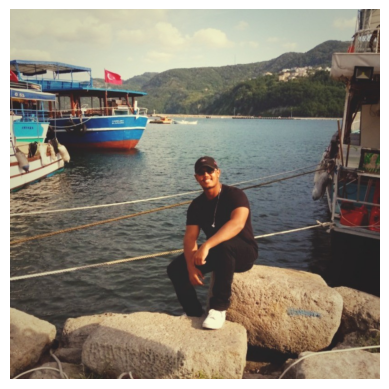

In [10]:

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("assets/ME.jpeg").convert("RGB")
plt.imshow(img)
plt.axis("off")

### 🔬 Visualize Step by Step 

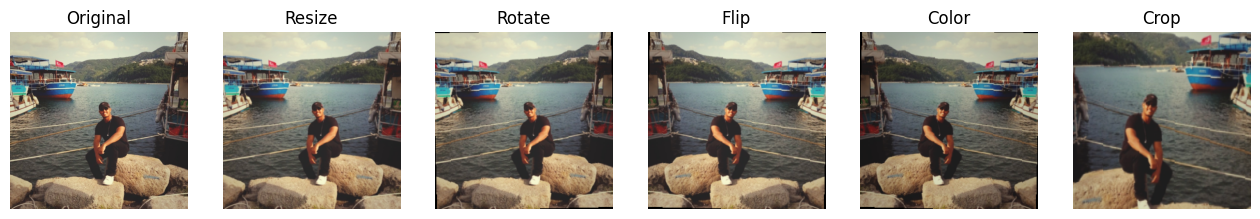

In [11]:
steps = [
    ("Resize", transforms.Resize((256, 256))),
    ("Rotate", transforms.RandomRotation(10)),
    ("Flip", transforms.RandomHorizontalFlip(p=1.0)),
    ("Color", transforms.ColorJitter(0.2, 0.2)),
    ("Crop", transforms.RandomResizedCrop(224, scale=(0.4, 1.0))),
]

fig, axes = plt.subplots(1, len(steps)+1, figsize=(16, 4))
axes[0].imshow(img); axes[0].set_title("Original"); axes[0].axis("off")

current = img
for i, (name, t) in enumerate(steps, 1):
    current = t(current)
    axes[i].imshow(current)
    axes[i].set_title(name)
    axes[i].axis("off")

plt.show()

### 🔁 Same Image, Different Results

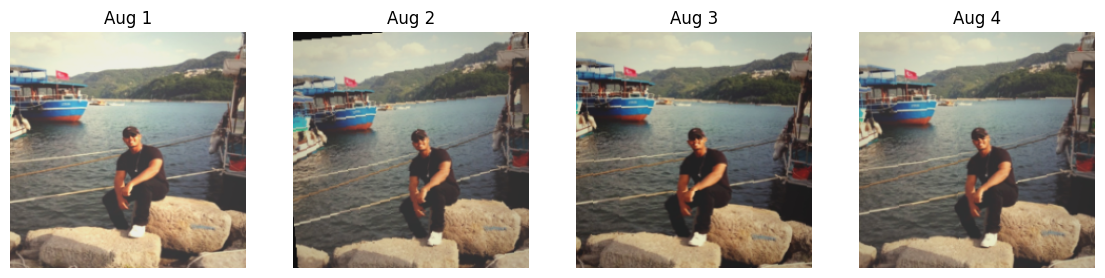

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

for i in range(4):
    out = image_transforms(img)
    out = out.permute(1, 2, 0)
    out = out * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
    axes[i].imshow(out.clamp(0,1))
    axes[i].set_title(f"Aug {i+1}")
    axes[i].axis("off")

plt.show()



### 🧠 Key Takeaways

* Augmentation = **controlled randomness**
* Same image → different tensor each epoch
* Use random transforms **only for training**

> **Transforms are regularization, not decoration.**

# Ok let's get back to the main pipline


## 🏗️ Simulate a Dataset Structure

Since we don't have real Sudanese plant images for demonstration, we will:

1. Create a temporary directory structure:
```

root_dir/
train/
healthy/
diseased/
val/
healthy/
diseased/

```
2. Generate dummy images as random RGB arrays.
3. Show how the dataset class handles lazy loading and augmentation.

> In a real scenario, replace the simulated dataset with a folder of real images.
``


In [13]:
import tempfile
# Temporary directory for demo
temp_dir = tempfile.mkdtemp()
train_dir = Path(temp_dir) / "train"
val_dir = Path(temp_dir) / "val"

for mode_dir in [train_dir, val_dir]:
    for class_name in ['healthy', 'diseased']:
        class_dir = mode_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)
        for i in range(5):  # 5 images per class for demo
            img_array = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
            img = Image.fromarray(img_array)
            img.save(class_dir / f"image_{i}.jpg")

print(f"Temporary dataset created at: {temp_dir}")

Temporary dataset created at: /tmp/tmpcqsj_4y9



## 🧩 Load Dataset and Inspect Samples

Now we instantiate the `SudanesePlantDataset` for both **train** and **validation** splits.  

We'll also show a few samples to visually confirm everything is working.

Loaded 10 images for train set
Classes: {'healthy': 0, 'diseased': 1}
Loaded 10 images for val set
Classes: {'healthy': 0, 'diseased': 1}
Training samples: 10
Validation samples: 10


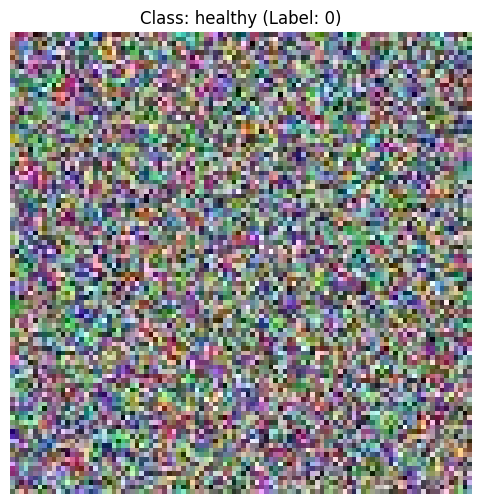

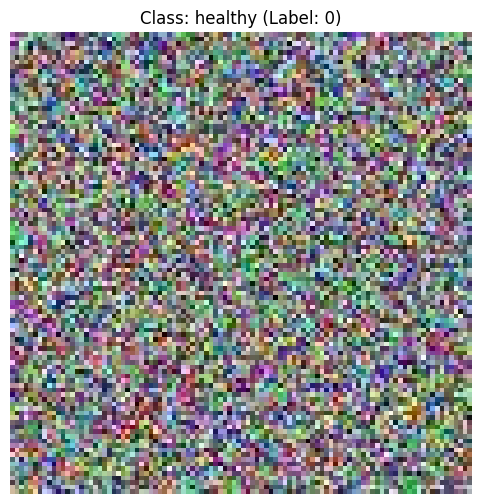

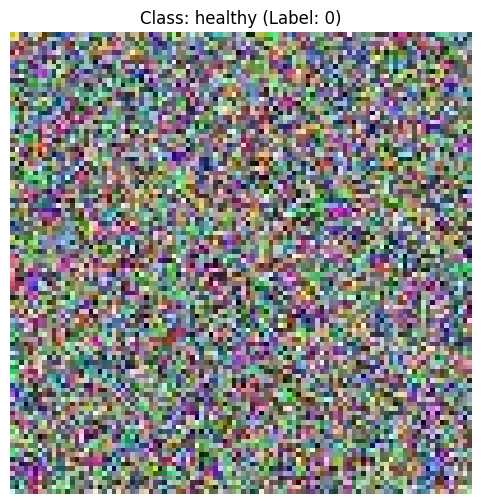

In [14]:
train_dataset = SudanesePlantDataset(temp_dir, mode='train')
val_dataset = SudanesePlantDataset(temp_dir, mode='val')

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Display a few training samples
for i in range(3):
    train_dataset.show_sample(i)

## ⚡ Create DataLoaders

- Batch loading with PyTorch `DataLoader`
- Optimized settings for training:
  - `num_workers` > 0 for parallel data loading
  - `pin_memory=True` for faster GPU transfer
  - `drop_last=True` for complete batches

> This is the core of an **efficient CV pipeline**.

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## ✅ Test Batch Loading

Let's fetch one batch and inspect its shape and labels to ensure the pipeline is working correctly.
```

In [16]:

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([8, 3, 224, 224])
Batch labels: tensor([1, 0, 0, 0, 0, 1, 1, 1])



## 🧹 Cleanup and Next Steps

- Remove temporary dataset:

In [17]:
import shutil
shutil.rmtree(temp_dir)
print(f"Temporary dataset at {temp_dir} removed")

Temporary dataset at /tmp/tmpcqsj_4y9 removed


## ⚡ Advanced Optimization: Memory Mapping for Large Images

For satellite imagery, medical scans, or other large images, we need specialized techniques. Memory mapping allows us to load only the parts of an image we need, without loading the entire file into memory.

In [18]:
print("="*60)
print("ADVANCED TECHNIQUE: Memory Mapping for Large Images")
print("="*60)

class MemoryMappedImageDataset(Dataset):
    """Dataset that uses memory mapping for large images"""
    
    def __init__(self, image_paths, labels, tile_size=512):
        """
        Args:
            image_paths: List of paths to large images
            labels: Corresponding labels
            tile_size: Size to tile large images into
        """
        self.image_paths = image_paths
        self.labels = labels
        self.tile_size = tile_size
        
        # Pre-calculate tile positions for each image
        self.tile_info = []
        
        for img_idx, img_path in enumerate(image_paths):
            # Get image dimensions without loading entire image
            with Image.open(img_path) as img:
                width, height = img.size
            
            # Calculate grid of tiles
            num_tiles_x = width // tile_size
            num_tiles_y = height // tile_size
            
            for y in range(num_tiles_y):
                for x in range(num_tiles_x):
                    self.tile_info.append({
                        'img_idx': img_idx,
                        'path': img_path,
                        'tile_x': x * tile_size,
                        'tile_y': y * tile_size,
                        'label': labels[img_idx]
                    })
        
        print(f"Created {len(self.tile_info)} tiles from {len(image_paths)} images")
    
    def __len__(self):
        return len(self.tile_info)
    
    def __getitem__(self, idx):
        """Load only the needed tile from large image"""
        info = self.tile_info[idx]
        
        # Open image and load only the tile region
        with Image.open(info['path']) as img:
            tile = img.crop((
                info['tile_x'],
                info['tile_y'],
                info['tile_x'] + self.tile_size,
                info['tile_y'] + self.tile_size
            ))
        
        # Convert to tensor
        tensor = transforms.ToTensor()(tile)
        
        return tensor, info['label']

print("\nMemory mapping is essential for:")
print("1. Satellite imagery (often 10,000×10,000 pixels)")
print("2. Medical scans (CT, MRI - GBs per scan)")
print("3. High-resolution microscopy")
print("\n💡 Key Insight: Load only what you need, not entire files!")

ADVANCED TECHNIQUE: Memory Mapping for Large Images

Memory mapping is essential for:
1. Satellite imagery (often 10,000×10,000 pixels)
2. Medical scans (CT, MRI - GBs per scan)
3. High-resolution microscopy

💡 Key Insight: Load only what you need, not entire files!


### **1️⃣ Motivation**

* Standard `Dataset` loads **full images into memory**.
* If images are huge (e.g., 10k × 10k pixels, several GBs), this **won’t fit in RAM**.
* Loading the entire image repeatedly is **slow** and **wasteful** if you only need small patches for training (e.g., CNN crops).


### **2️⃣ What this class does: Memory-Mapped Tiles**

`MemoryMappedImageDataset` splits **large images into smaller tiles** (like 512×512 patches) and loads **only the tile needed** at a given `__getitem__` call.

* **`tile_info`**: Precomputes which tiles exist for every image.
* **Lazy loading**: Images are opened **just-in-time**, only the needed tile is read.
* **Tile cropping**: Uses `PIL.Image.crop()` to extract small regions instead of full image.
* **Tensor conversion**: Converts cropped tile to PyTorch tensor for model input.


### **3️⃣ How it works**

1. **Initialization (`__init__`)**

   * Loops through each image path.
   * Reads image dimensions **without loading all pixels into memory**.
   * Computes how many tiles can fit along width and height.
   * Stores **tile coordinates** in `self.tile_info`.

2. **Length (`__len__`)**

   * Returns the total number of tiles across all images.

3. **Get Item (`__getitem__`)**

   * Retrieves the `tile_info` for index `idx`.
   * Opens the image **temporarily**, crops the tile, converts to tensor.
   * Returns `(tile_tensor, label)`.


### **4️⃣ Why it matters**

* Handles **gigantic images efficiently**.
* Reduces **memory footprint** drastically.
* Allows **training CNNs on high-res data** without downsampling or crashing.
* Works seamlessly with PyTorch `DataLoader` for **batching, shuffling, and augmentation**.


### **5️⃣ Example Use Cases**

| Domain                   | Image Size     | Challenge                    | Solution with Tiles |
| ------------------------ | -------------- | ---------------------------- | ------------------- |
| Satellite imagery        | 10000×10000 px | Cannot fit full image in RAM | 512×512 tiles       |
| Medical scans (CT, MRI)  | GBs per scan   | Loading full volume is slow  | Patch-level tiles   |
| Microscopy (cell images) | 5000×5000 px   | High-res details matter      | Tile extraction     |


### **💡 Key Insight**

> **Load only what you need, when you need it.**
> Memory mapping + tiling allows **scaling CV pipelines to massive datasets** that otherwise would break standard loading methods.



## ✅ Step 1 — Create REALISTIC “Large” Images (Simulated but Legit)

We simulate **very large images (4096×4096)** on disk — this mimics satellite / medical data without downloading huge files.



In [19]:
import numpy as np
from PIL import Image
from pathlib import Path
import tempfile
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


print("\nCreating large test images...")

# Temporary directory
temp_dir = Path(tempfile.mkdtemp())

image_paths = []
labels = []

# Create 2 large images (4K x 4K)
for i in range(2):
    img_array = np.random.randint(
        0, 255, (4096, 4096, 3), dtype=np.uint8
    )
    img = Image.fromarray(img_array, "RGB")
    
    img_path = temp_dir / f"large_image_{i}.png"
    img.save(img_path)
    
    image_paths.append(str(img_path))
    labels.append(i % 2)  # binary labels

print(f"Saved {len(image_paths)} large images at: {temp_dir}")



Creating large test images...
Saved 2 large images at: /tmp/tmpku3u28_2


📌 **Why this matters**
These files are **real images on disk**, not tensors in RAM.
This is exactly what memory mapping is designed for.

---

## ✅ Step 2 — Instantiate the Memory-Mapped Dataset


Just tell me **which one you want next** and I’ll extend this cleanly 💪


In [20]:
dataset = MemoryMappedImageDataset(
    image_paths=image_paths,
    labels=labels,
    tile_size=512
)

print(f"Total tiles in dataset: {len(dataset)}")

Created 128 tiles from 2 images
Total tiles in dataset: 128


🧠 **Interpretation**

* Each 4096×4096 image → `(4096 / 512)² = 64 tiles`
* 2 images → **128 samples**
* Dataset length = number of **tiles**, not images


## ✅ Step 3 — Test Single Tile Loading (Critical!)

This confirms **only a tile is loaded**, not the full image.


In [21]:
tile, label = dataset[0]

print("Single tile test:")
print(f"Tile shape: {tile.shape}")
print(f"Label: {label}")

Single tile test:
Tile shape: torch.Size([3, 512, 512])
Label: 0


## ✅ Step 4 — Visualize a Tile (Student Intuition Booster)


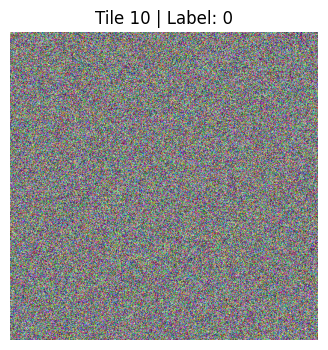

In [22]:
def show_tile(dataset, idx):
    tile, label = dataset[idx]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(tile.permute(1, 2, 0))
    plt.title(f"Tile {idx} | Label: {label}")
    plt.axis("off")
    plt.show()

show_tile(dataset, idx=10)

🎯 This is **hugely important pedagogically**:

* The model **never sees the whole image**
* Training happens on **local patches**

---

## ✅ Step 5 — DataLoader Stress Test (Real Pipeline Use)


In [23]:

loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("\nTesting DataLoader batches:")
for images, labels in loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    break


Testing DataLoader batches:
Batch shape: torch.Size([8, 3, 512, 512])
Labels: tensor([1, 1, 0, 0, 0, 0, 0, 0])


This proves:

* Works with batching
* Works with multiprocessing
* GPU-friendly pipeline

---

## 🧠 What you Should Understand After This Section

### 🔹 Conceptual Jump

| Naive Dataset          | Memory-Mapped Dataset        |
| ---------------------- | ---------------------------- |
| Loads full image       | Loads **only required tile** |
| RAM-heavy              | RAM-efficient                |
| Crashes on huge images | Scales to TB datasets        |
| Simple CV              | **Production CV**            |

---

## 💡 
> “In real computer vision systems, **we never load the whole image**.
> We stream **just enough pixels** to keep the GPU busy.”

# PART 5: NLP Pipeline for Arabic Text

Now let's tackle another crucial data type: text. We'll focus on Arabic text processing, which is essential for Sudanese applications. This requires handling right-to-left text, vocabulary building, and variable-length sequences.

## 📚 Handling Arabic Text Data

Let's build a dataset for Arabic text classification, useful for Sudanese news categorization, social media analysis, and more.

As a start this is a full implrmementation of a basic dataset for Arabic text classification.we will work backwards from here to build a full pipeline including tokenization, padding, and batching.

In [24]:
print("="*60)
print("NLP PIPELINE: Arabic Text Classification")
print("="*60)

class ArabicTextDataset(Dataset):
    """Dataset for Arabic text classification"""
    
    def __init__(self, texts, labels, vocab=None, max_length=128):
        """
        Args:
            texts: List of Arabic text strings
            labels: List of integer labels
            vocab: Optional vocabulary dict {word: idx}
            max_length: Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        
        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = self.build_vocab(texts)
        else:
            self.vocab = vocab
        
        # Special tokens
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.vocab[self.pad_token] = 0
        self.vocab[self.unk_token] = 1
        
        # Reverse vocabulary for debugging
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}
        
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Number of samples: {len(self)}")
    
    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from Arabic texts"""
        from collections import Counter
        
        # Simple word-level tokenizer for Arabic
        word_counts = Counter()
        
        for text in texts:
            # Split on whitespace (simple tokenization)
            # In production, use proper Arabic tokenizer
            words = text.split()
            word_counts.update(words)
        
        # Filter by frequency
        vocab = {}
        idx = 2  # Start after special tokens
        
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = idx
                idx += 1
        
        return vocab
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """Convert text to token indices"""
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize
        tokens = text.split()
        
        # Convert to indices
        indices = []
        for token in tokens:
            if token in self.vocab:
                indices.append(self.vocab[token])
            else:
                indices.append(self.vocab[self.unk_token])
        
        # Pad or truncate
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        else:
            indices = indices + [self.vocab[self.pad_token]] * (self.max_length - len(indices))
        
        # Convert to tensors
        text_tensor = torch.tensor(indices, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return text_tensor, label_tensor
    
    def decode(self, indices):
        """Convert indices back to text for debugging"""
        words = []
        for idx in indices:
            if idx in self.idx_to_word:
                words.append(self.idx_to_word[idx])
            else:
                words.append(self.unk_token)
        
        # Remove padding
        words = [w for w in words if w != self.pad_token]
        return ' '.join(words)

# Sample Arabic texts (Sudanese news categories)
sample_texts = [
    "وزير المالية يعلن عن موازنة العام الجديد",  # Politics
    "موسم الحصاد يبدأ في ولاية الجزيرة",  # Agriculture
    "منتخب السودان يتأهل للبطولة العربية",  # Sports
    "دراسة جديدة عن التعليم في المناطق الريفية",  # Education
    "أسعار المحاصيل ترتفع في الأسواق المحلية",  # Economy
]

sample_labels = [0, 1, 2, 3, 1]  # Politics, Agriculture, Sports, Education, Agriculture

# Test our dataset
print("\nTesting Arabic Text Dataset:")

arabic_dataset = ArabicTextDataset(sample_texts, sample_labels, max_length=20)

print(f"\nSample 0:")
text_tensor, label = arabic_dataset[0]
print(f"  Text tensor shape: {text_tensor.shape}")
print(f"  Label: {label}")
print(f"  Decoded: {arabic_dataset.decode(text_tensor)}")

# Custom collate function for variable-length sequences
def collate_fn_padding(batch):
    """Collate function that pads sequences to same length"""
    texts, labels = zip(*batch)
    
    # Find max length in this batch
    lengths = [len(text) for text in texts]
    max_length = max(lengths)
    
    # Pad all sequences to max length
    padded_texts = []
    for text in texts:
        padding = max_length - len(text)
        padded_text = torch.cat([text, torch.zeros(padding, dtype=torch.long)])
        padded_texts.append(padded_text)
    
    # Stack
    texts_tensor = torch.stack(padded_texts)
    labels_tensor = torch.stack(labels)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)
    
    return texts_tensor, labels_tensor, lengths_tensor

# Create DataLoader with custom collate
arabic_loader = DataLoader(
    arabic_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn_padding
)

print("\nTesting batched loading with padding:")
for texts, labels, lengths in arabic_loader:
    print(f"Batch shape: {texts.shape}")
    print(f"Labels: {labels}")
    print(f"Lengths: {lengths}")
    break

NLP PIPELINE: Arabic Text Classification

Testing Arabic Text Dataset:
Vocabulary size: 4
Number of samples: 5

Sample 0:
  Text tensor shape: torch.Size([20])
  Label: 0
  Decoded: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

Testing batched loading with padding:
Batch shape: torch.Size([2, 20])
Labels: tensor([3, 1])
Lengths: tensor([20, 20])


# 📓 Building a Modern NLP Data Pipeline
### From Raw Arabic Text → Transformer-Ready Batches




## 🧭  Philosophy

This section answers **one question**:

> **How does raw Arabic text become tensors that a model can train on?**

We will:

1. Build everything **by hand** (to understand)
2. Replace it with **professional tools** (to ship)
3. Keep the **same mental model throughout** 

# 🧱 PART 1 — The NLP Data Pipeline Mental Model

## 1️⃣ The Universal NLP Flow

```text
Raw Text
   ↓
Tokenization
   ↓
Numerical Encoding
   ↓
Padding / Truncation
   ↓
Batching
   ↓
Model
```

🧠 **Key rule**

> Models do NOT understand text
> They ONLY understand numbers

---

## 2️⃣ Dataset vs DataLoader (Critical Separation)

| Component  | Responsibility                   |
| ---------- | -------------------------------- |
| Dataset    | “What is ONE sample?”            |
| DataLoader | “How do samples become batches?” |

Never mix these responsibilities.

---

# 🧠 PART 2 — NLP From First Principles (Manual)

## 3️⃣ Problem Setup: Arabic Text Classification

**Task**: Classify Arabic news text
**Input**: Arabic sentences
**Output**: Category label (int)

---

## 4️⃣ Raw Data (Small but Real)

In [25]:
texts = [
    "وزير المالية يعلن عن موازنة العام الجديد",
    "موسم الحصاد يبدأ في ولاية الجزيرة",
    "منتخب السودان يتأهل للبطولة العربية",
    "دراسة جديدة عن التعليم في المناطق الريفية",
    "أسعار المحاصيل ترتفع في الأسواق المحلية",
]

labels = [0, 1, 2, 3, 1]

## 5️⃣ Manual Tokenization (Why This Exists)

We intentionally start **simple**.

In [26]:

tokens = texts[0].split()
tokens


['وزير', 'المالية', 'يعلن', 'عن', 'موازنة', 'العام', 'الجديد']

## 6️⃣ Vocabulary Construction (Feature Space)

In [27]:
from collections import Counter

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

vocab = build_vocab(texts)
vocab

{'<PAD>': 0, '<UNK>': 1, 'عن': 2, 'في': 3}

🧠 Vocabulary = **learned feature dictionary**


## 7️⃣ Encoding Text → Numbers


In [28]:

def encode(text, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in text.split()]

encode(texts[0], vocab)


[1, 1, 1, 2, 1, 1, 1]

## 8️⃣ Padding & Truncation (Sequence Control)


In [29]:
def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))

## 9️⃣ Dataset Class (The Core Abstraction)

In [30]:

class ArabicTextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=20):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoded = encode(self.texts[idx], self.vocab)
        padded = pad_sequence(encoded, self.max_length)
        
        return (
            torch.tensor(padded, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )


🧠 **Golden rule**

> `__getitem__` returns ONE sample — always

---

## 10️⃣ Dataset Sanity Check


In [31]:

dataset = ArabicTextDataset(texts, labels, vocab)

x, y = dataset[0]
x, y

(tensor([1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(0))

# ⚙️ PART 3 — Batching & DataLoader

## 11️⃣ Why Batching Is NOT in Dataset

Because batching:

* is parallel
* is hardware-dependent
* changes during training


In [32]:

loader = DataLoader(dataset, batch_size=2, shuffle=True)

print("\nTesting batched loading with padding:")
for texts, labels in loader:
    print(f"Batch shape: {texts.shape}")
    print(f"Labels: {labels}")
    break


Testing batched loading with padding:
Batch shape: torch.Size([2, 20])
Labels: tensor([3, 1])



# 🚀 PART 4 — Professional NLP (Tokenizer-Driven)

Now that we **understand everything**, we switch tools.

---

## 13️⃣ Real Tokenizer (Arabic BERT)



In [33]:

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")


## 14️⃣ Transformer-Ready Dataset


In [35]:
class ArabicTextDatasetHF(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = [str(t) for t in texts]  # FORCE string
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]  # ✅ str

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.texts)


## 15️⃣ Production DataLoader


In [36]:
loader = DataLoader(
    ArabicTextDatasetHF(texts, labels, tokenizer),
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


batch = next(iter(loader))
batch.keys()

/tmp/ipykernel_3115087/2413137350.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(self.labels[idx])


dict_keys(['input_ids', 'attention_mask', 'labels'])

# 🧠 PART 5 — Mental Model Lock-In


## What You Now Understand


✔ Why tokenizers exist

✔ Why padding is mandatory

✔ Why attention masks matter

✔ Why Dataset ≠ DataLoader

✔ Why tools are abstractions, not magic


# PART 6: Advanced Techniques & Optimization

Now that we've covered the fundamentals, let's explore advanced patterns used in production systems. These techniques handle edge cases and optimize for specific scenarios.

## 🚀 Professional Patterns for Production

In this section, we explore **techniques used in production** for handling large-scale datasets:

1. **Streaming datasets** — process data too large to fit in memory.
2. **Caching datasets** — speed up repeated access with in-memory caches.
3. **Domain-specific augmentations** — flexible image augmentation pipelines.
4. **Parallel dataset loading** — handle multiple datasets efficiently.

## **Streaming Dataset**

In [37]:
from torch.utils.data import IterableDataset

print("="*60)
print("1️⃣ Streaming Dataset (IterableDataset)")
print("="*60)

class StreamingSudaneseNews(IterableDataset):
    """Dataset that streams data from a file or API"""
    
    def __init__(self, file_path, chunk_size=1000):
        self.file_path = file_path
        self.chunk_size = chunk_size
        
    def __iter__(self):
        """Stream data line by line"""
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:  # Single-process data loading
            start, end = 0, None
        else:  # Multi-process data loading
            per_worker = self.chunk_size // worker_info.num_workers
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = start + per_worker
        
        with open(self.file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if end is not None and i >= end:
                    break
                if i >= start:
                    yield line.strip(), i % 5  # Dummy label for demo

1️⃣ Streaming Dataset (IterableDataset)


### 🔹 Why IterableDataset?

- Useful for **streaming large text or image datasets**.
- Data is **never fully loaded into memory**.
- Works with **multi-process DataLoader**.

## **Cached Dataset**

In [38]:
from collections import OrderedDict

class CachedDataset(Dataset):
    def __init__(self, base_dataset, cache_size=1000):
        self.base_dataset = base_dataset
        self.cache_size = cache_size
        self.cache = OrderedDict()
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        if idx in self.cache:
            self.cache.move_to_end(idx)  # mark as recently used
            return self.cache[idx]
        
        data = self.base_dataset[idx]
        
        if len(self.cache) >= self.cache_size:
            self.cache.popitem(last=False)  # evict LRU
        
        self.cache[idx] = data
        return data



### 🔹 Why Cache?

- Speeds up **frequently accessed samples** (training loops, repeated validation).
- Implements a **simple LRU-like strategy** to keep memory usage under control.

## **Augmentation Factory**

In [40]:

print("="*60)
print("3️⃣ Augmentation Factory")
print("="*60)

class AugmentationFactory:
    """Creates augmentation pipelines based on dataset characteristics"""
    
    @staticmethod
    def create_for_sudanese_images(image_type='general', augment=True):
        base_transforms = [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]
        
        if not augment:
            return transforms.Compose(base_transforms)
        
        augmentations = []
        
        if image_type == 'agriculture':
            augmentations.extend([
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.3, contrast=0.3),
                transforms.RandomHorizontalFlip(p=0.5),
            ])
        elif image_type == 'satellite':
            augmentations.extend([
                transforms.RandomCrop(224),
                transforms.RandomVerticalFlip(p=0.5),
            ])
        else:
            augmentations.extend([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2),
            ])
        
        return transforms.Compose(augmentations + base_transforms)

# Demo
for img_type in ['agriculture', 'satellite', 'general']:
    aug = AugmentationFactory.create_for_sudanese_images(img_type, augment=True)
    print(f"{img_type}: {len(aug.transforms)} transforms")

3️⃣ Augmentation Factory
agriculture: 6 transforms
satellite: 5 transforms
general: 5 transforms


### 🔹 Why Use a Factory?

- Flexibly create **different augmentation pipelines** depending on the domain.
- Keeps augmentation logic **centralized and maintainable**.
- Can dynamically switch **training vs inference transforms**.

## **Parallel Dataset Loading**

In [41]:
import os
from torch.utils.data import DataLoader

print("="*60)
print("4️⃣ Parallel Dataset Loader")
print("="*60)

class ParallelDatasetLoader:
    """Utility for loading multiple datasets in parallel"""
    
    def __init__(self, datasets, batch_sizes=None):
        self.datasets = datasets
        self.batch_sizes = batch_sizes or [32] * len(datasets)
        self.dataloaders = []
        
        for dataset, batch_size in zip(datasets, self.batch_sizes):
            loader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=min(4, os.cpu_count() // len(datasets)),
                pin_memory=True,
                persistent_workers=True
            )
            self.dataloaders.append(loader)
    
    def get_iterators(self):
        return [iter(loader) for loader in self.dataloaders]

4️⃣ Parallel Dataset Loader



### 🔹 Why Parallel Loading?

- Useful when training **multi-task models** or **ensembles**.
- Ensures each dataset is loaded **efficiently** in parallel.
- Avoids sequential bottlenecks in preprocessing.
```


# PART 7: Debugging & Performance Profiling

Building efficient pipelines isn't enough - we need to know how to diagnose and fix performance issues. Let's create tools to profile our data pipelines and identify bottlenecks.

## 🔧 Diagnosing Data Loading Issues

We'll build a DataPipelineProfiler class that measures batch loading times, memory usage, and identifies common bottlenecks.

DEBUGGING & PROFILING: Find Your Bottlenecks

Profiling different DataLoader configurations:

1. Suboptimal configuration (num_workers=0):

Profiling DataLoader with 20 batches...

📊 PROFILING REPORT:
Average batch time: 91.1 ms
Std batch time: 27.0 ms
Min batch time: 25.1 ms
Max batch time: 106.1 ms

Peak memory usage: 3530.6 MB
Average memory usage: 3530.6 MB


2. Optimized configuration (num_workers=4):

Profiling DataLoader with 20 batches...

📊 PROFILING REPORT:
Average batch time: 71.1 ms
Std batch time: 147.0 ms
Min batch time: 0.0 ms
Max batch time: 428.8 ms

Peak memory usage: 3582.8 MB
Average memory usage: 3577.6 MB

⚠️  INCONSISTENT PERFORMANCE: Variable batch times
   Possible causes:
   • Mixed file sizes
   • Network latency (cloud storage)

PROFILING INSIGHTS:
1. Use num_workers > 0 for parallel loading
2. Monitor batch times for consistency
3. Watch memory usage for leaks
4. Profile regularly as dataset grows


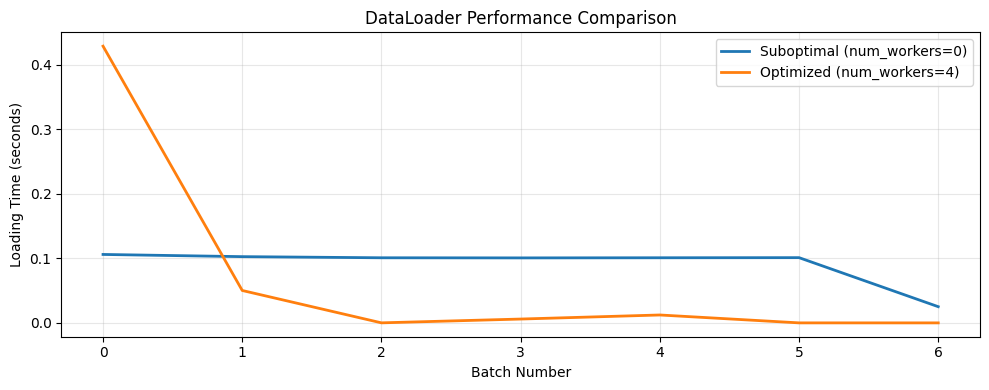

In [42]:
print("="*60)
print("DEBUGGING & PROFILING: Find Your Bottlenecks")
print("="*60)

class DataPipelineProfiler:
    """Profiler for data loading pipelines"""
    
    def __init__(self):
        self.metrics = {
            'load_times': [],
            'batch_times': [],
            'gpu_wait_times': [],
            'memory_usage': []
        }
    
    def profile_dataloader(self, dataloader, num_batches=10):
        """Profile a DataLoader"""
        print(f"\nProfiling DataLoader with {num_batches} batches...")
        
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            batch_time = time.time() - start_time
            self.metrics['batch_times'].append(batch_time)
            
            # Measure memory usage
            memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
            self.metrics['memory_usage'].append(memory_mb)
            
            # Reset timer for next batch
            start_time = time.time()
            
            if batch_idx >= num_batches - 1:
                break
        
        self.print_report()
    
    def print_report(self):
        """Print profiling report"""
        if not self.metrics['batch_times']:
            print("No data collected")
            return
        
        batch_times = self.metrics['batch_times']
        memory_usage = self.metrics['memory_usage']
        
        print("\n📊 PROFILING REPORT:")
        print("="*40)
        print(f"Average batch time: {np.mean(batch_times)*1000:.1f} ms")
        print(f"Std batch time: {np.std(batch_times)*1000:.1f} ms")
        print(f"Min batch time: {np.min(batch_times)*1000:.1f} ms")
        print(f"Max batch time: {np.max(batch_times)*1000:.1f} ms")
        print(f"\nPeak memory usage: {np.max(memory_usage):.1f} MB")
        print(f"Average memory usage: {np.mean(memory_usage):.1f} MB")
        
        # Diagnose bottlenecks
        avg_batch_time = np.mean(batch_times)
        if avg_batch_time > 0.1:  # More than 100ms per batch
            print("\n⚠️  BOTTLENECK DETECTED: Slow data loading")
            print("   Possible causes:")
            print("   • Disk I/O too slow")
            print("   • Data augmentation too heavy")
            print("   • num_workers too low")
        
        if np.std(batch_times) > avg_batch_time * 0.5:
            print("\n⚠️  INCONSISTENT PERFORMANCE: Variable batch times")
            print("   Possible causes:")
            print("   • Mixed file sizes")
            print("   • Network latency (cloud storage)")
    
    def plot_metrics(self):
        """Plot profiling metrics"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Batch times
        axes[0].plot(self.metrics['batch_times'])
        axes[0].set_xlabel('Batch Number')
        axes[0].set_ylabel('Time (seconds)')
        axes[0].set_title('Batch Loading Times')
        axes[0].grid(True, alpha=0.3)
        
        # Memory usage
        axes[1].plot(self.metrics['memory_usage'])
        axes[1].set_xlabel('Batch Number')
        axes[1].set_ylabel('Memory (MB)')
        axes[1].set_title('Memory Usage')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create a test dataset
class TestDataset(Dataset):
    def __init__(self, num_samples=100, delay=0.01):
        self.num_samples = num_samples
        self.delay = delay
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        time.sleep(self.delay)  # Simulate I/O delay
        return torch.randn(3, 224, 224), torch.randint(0, 10, (1,)).item()

# Test with different configurations
print("\nProfiling different DataLoader configurations:")

test_dataset = TestDataset(num_samples=100, delay=0.005)

# Configuration 1: Suboptimal
print("\n1. Suboptimal configuration (num_workers=0):")
dataloader_slow = DataLoader(test_dataset, batch_size=16, num_workers=0)
profiler1 = DataPipelineProfiler()
profiler1.profile_dataloader(dataloader_slow, num_batches=20)

# Configuration 2: Optimized
print("\n\n2. Optimized configuration (num_workers=4):")
dataloader_fast = DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
profiler2 = DataPipelineProfiler()
profiler2.profile_dataloader(dataloader_fast, num_batches=20)

print("\n" + "="*60)
print("PROFILING INSIGHTS:")
print("="*60)
print("1. Use num_workers > 0 for parallel loading")
print("2. Monitor batch times for consistency")
print("3. Watch memory usage for leaks")
print("4. Profile regularly as dataset grows")

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 4))
batch_numbers = range(len(profiler1.metrics['batch_times']))
ax.plot(batch_numbers, profiler1.metrics['batch_times'], 
        label='Suboptimal (num_workers=0)', linewidth=2)
ax.plot(batch_numbers, profiler2.metrics['batch_times'], 
        label='Optimized (num_workers=4)', linewidth=2)
ax.set_xlabel('Batch Number')
ax.set_ylabel('Loading Time (seconds)')
ax.set_title('DataLoader Performance Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PART 8: Summary & Best Practices

We've covered a comprehensive range of data pipeline techniques. Let's consolidate our learning with key takeaways, templates, and best practices for production systems.

## 📚 Key Takeaways

Here's what you should remember from this lecture:

In [43]:
print("="*60)
print("PYTORCH DATA PIPELINES - KEY TAKEAWAYS")
print("="*60)

takeaways = """
🎯 1. Dataset Design Patterns:
    • Small data → Load in __init__
    • Large data → Load in __getitem__
    • Massive data → Streaming/IterableDataset

🎯 2. DataLoader Optimization:
    • num_workers: 2-4 × CPU cores
    • pin_memory: True for GPU training
    • prefetch_factor: 2 for smooth loading
    • persistent_workers: True for faster epoch transitions

🎯 3. Sudanese-Specific Considerations:
    • Handle Arabic text encoding
    • Optimize for limited bandwidth
    • Use memory-efficient formats
    • Plan for intermittent connectivity

🎯 4. Production Best Practices:
    • Always handle corrupted files gracefully
    • Use caching for frequently accessed data
    • Profile and monitor loading performance
    • Version your data pipelines
"""
print(takeaways)

PYTORCH DATA PIPELINES - KEY TAKEAWAYS

🎯 1. Dataset Design Patterns:
    • Small data → Load in __init__
    • Large data → Load in __getitem__
    • Massive data → Streaming/IterableDataset

🎯 2. DataLoader Optimization:
    • num_workers: 2-4 × CPU cores
    • pin_memory: True for GPU training
    • prefetch_factor: 2 for smooth loading
    • persistent_workers: True for faster epoch transitions

🎯 3. Sudanese-Specific Considerations:
    • Handle Arabic text encoding
    • Optimize for limited bandwidth
    • Use memory-efficient formats
    • Plan for intermittent connectivity

🎯 4. Production Best Practices:
    • Always handle corrupted files gracefully
    • Use caching for frequently accessed data
    • Profile and monitor loading performance
    • Version your data pipelines



## 🧪 The Minimal Production-Ready Dataset

Here's a template you can use as a starting point for any production dataset. It includes error handling, caching, and proper structure.

In [44]:
print("\n" + "="*60)
print("MINIMAL PRODUCTION DATASET TEMPLATE")
print("="*60)

minimal_template = '''
# Production Dataset Template
class ProductionDataset(Dataset):
    def __init__(self, data_path, transform=None):
        super().__init__()
        
        # 1. Load metadata (not data!)
        self.data_path = Path(data_path)
        self.samples = self._load_metadata()
        
        # 2. Set up transformations
        self.transform = transform or self._default_transform()
        
        # 3. Initialize cache (if needed)
        self.cache = {}
        
        print(f"Loaded {len(self)} samples")
    
    def _load_metadata(self):
        """Load file paths and labels"""
        samples = []
        # Your metadata loading logic here
        return samples
    
    def _default_transform(self):
        """Default data transformations"""
        return None  # Your default transforms here
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            return self.cache[idx]
        
        try:
            # Load data
            data = self._load_sample(idx)
            
            # Apply transformations
            if self.transform:
                data = self.transform(data)
            
            # Cache if appropriate
            if len(self.cache) < 1000:  # Limit cache size
                self.cache[idx] = data
            
            return data
            
        except Exception as e:
            # Handle errors gracefully
            print(f"Error loading sample {idx}: {e}")
            return self._get_placeholder()  # Return placeholder
    
    def _load_sample(self, idx):
        """Load actual data for one sample"""
        # Your data loading logic here
        pass
    
    def _get_placeholder(self):
        """Return placeholder for corrupted data"""
        # Your placeholder logic here
        pass
'''
print(minimal_template)


MINIMAL PRODUCTION DATASET TEMPLATE

# Production Dataset Template
class ProductionDataset(Dataset):
    def __init__(self, data_path, transform=None):
        super().__init__()

        # 1. Load metadata (not data!)
        self.data_path = Path(data_path)
        self.samples = self._load_metadata()

        # 2. Set up transformations
        self.transform = transform or self._default_transform()

        # 3. Initialize cache (if needed)
        self.cache = {}

        print(f"Loaded {len(self)} samples")

    def _load_metadata(self):
        """Load file paths and labels"""
        samples = []
        # Your metadata loading logic here
        return samples

    def _default_transform(self):
        """Default data transformations"""
        return None  # Your default transforms here

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            return self.cache[idx]

       

## ✍️ Exercises

Test your understanding with these exercises:

### Exercise 1: Fix the Bottleneck
This DataLoader has a performance issue. Identify and fix it:
```python
# Current implementation
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # Problem here
    pin_memory=False
)
```

### Exercise 2: Handle Large Images
Create a Dataset class that can handle 10,000×10,000 satellite images without loading them entirely into memory.

### Exercise 3: Arabic Text Preprocessing
Extend the ArabicTextDataset to:
1. Handle right-to-left text
2. Remove diacritics if present
3. Normalize Arabic characters

### Exercise 4: Data Pipeline for Sudanese Healthcare
Design a dataset for medical imaging in Sudanese hospitals that:
1. Handles DICOM files (medical images)
2. Includes patient metadata
3. Respects patient privacy
4. Works with limited internet connectivity

## ✅ Mastery Checklist

Before moving to the next lecture, ensure you can do all of the following:

- [ ] Create custom Dataset classes for tabular, image, and text data
- [ ] Optimize DataLoader parameters for maximum performance
- [ ] Implement data augmentation pipelines
- [ ] Handle large datasets with memory mapping
- [ ] Build multi-modal datasets (images + text)
- [ ] Create streaming datasets for cloud storage
- [ ] Profile and debug data loading bottlenecks
- [ ] Handle Arabic text encoding and preprocessing
- [ ] Implement error handling for corrupted data
- [ ] Design datasets for Sudanese-specific applications

If you can check all these boxes, you have mastered professional data pipelines with PyTorch!

## 📚 Practice & Reflection

### 🔍 **Conceptual Questions**

1. **What's the difference between `Dataset` and `IterableDataset`?**
   - When would you use each?
   - What are the performance implications?

2. **How does `num_workers` affect performance?**
   - What happens if you set it too high?
   - What's the optimal value for your machine?

3. **Why is `pin_memory` important for GPU training?**
   - What does it actually do?
   - When should you not use it?

4. **How do you handle datasets that don't fit in memory?**
   - What techniques can you use?
   - How does this affect training speed?

### 🎯 **Sudanese Context Questions**

1. **How would you design a data pipeline for:**
   - Sudanese dialect Arabic speech recognition?
   - Crop disease detection from mobile phone photos?
   - Market price prediction from SMS messages?

2. **What special considerations are needed for:**
   - Limited internet connectivity?
   - Power outages during training?
   - Multi-format data (SMS, WhatsApp, photos)?

<div align="center">
  
### **🌟 Building Sudan's AI Future, One Dataset at a Time**

*"Good data pipelines don't just load data—they enable research, empower communities, and build resilient AI systems."*

🇸🇩 **SAIR Community - Sudanese Artificial Intelligence Research**

</div>